In [47]:

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import AveragePooling2D, Dense, Flatten, Conv2D, MaxPool2D

from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt

from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method

In [52]:
class CustomLayer(layers.Layer):

    def __init__(self, units=32, activation='relu'):
        super(CustomLayer, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        #print(input_shape)
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.mask = self.add_weight(shape=(self.w.shape),
                                    initializer='ones',
                                    trainable=False)
        self.pruned_w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='ones',
                                 trainable=False)
        
    def call(self, inputs):
        #self.mask_2 = tf.multiply(self.mask, self.mask_2)
        self.pruned_w = tf.multiply(self.w, self.mask)
        #print('layer inputy', inputs.shape)
        x = tf.matmul(inputs, self.pruned_w)
        
        if self.activation == 'relu':
            return tf.keras.activations.relu(x)
        if self.activation == 'softmax':
            return tf.keras.activations.softmax(x)
        raise ValueError('Activation function not implemented')


class LeNet300_100(tf.keras.Model):
    def __init__(self):
        super(LeNet300_100, self).__init__()

        self.dense1 = CustomLayer(300)
        self.dense2 = CustomLayer(100)
        self.dense3 = CustomLayer(10, activation='softmax')
        
    def call(self, inputs):
        x = tf.keras.layers.Flatten()(inputs)
        #print('NN call',inputs.shape)
        x = self.dense1(x)
        
        x = self.dense2(x)
        #print(x.shape)
        return self.dense3(x)
    


In [56]:
def ld_mnist():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label

    dataset, info = tfds.load('mnist', 
                              data_dir='gs://tfds-data/datasets', 
                              with_info=True,
                              as_supervised=True)
    mnist_train, mnist_test = dataset['train'], dataset['test']
    mnist_train = mnist_train.map(convert_types).shuffle(10000).batch(128)
    mnist_test = mnist_test.map(convert_types).batch(128)
    return EasyDict(train=mnist_train, test=mnist_test)
data = ld_mnist()

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [60]:
model = LeNet300_100()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
              metrics=['accuracy'],
              experimental_run_tf_function=False
             )
#model.run_eagerly= True
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(x=x_train,
          y=y_train,
          batch_size=64,
          epochs=5000,
          callbacks=[callback],
          validation_data=(x_test, y_test),
         )

Train on 60000 samples, validate on 10000 samples
Epoch 1/5000
60000/60000 [==============================] - 4s 69us/sample - loss: 1.5735 - accuracy: 0.9008 - val_loss: 1.5184 - val_accuracy: 0.9469
Epoch 2/5000
60000/60000 [==============================] - 4s 73us/sample - loss: 1.5108 - accuracy: 0.9534 - val_loss: 1.5016 - val_accuracy: 0.9614
Epoch 3/5000
60000/60000 [==============================] - 4s 66us/sample - loss: 1.4975 - accuracy: 0.9652 - val_loss: 1.5001 - val_accuracy: 0.9615
Epoch 4/5000
60000/60000 [==============================] - 4s 67us/sample - loss: 1.4920 - accuracy: 0.9701 - val_loss: 1.4915 - val_accuracy: 0.9708
Epoch 5/5000
60000/60000 [==============================] - 5s 83us/sample - loss: 1.4869 - accuracy: 0.9752 - val_loss: 1.4928 - val_accuracy: 0.9690
Epoch 6/5000
60000/60000 [==============================] - 6s 103us/sample - loss: 1.4834 - accuracy: 0.9787 - val_loss: 1.4907 - val_accuracy: 0.9714
Epoch 7/5000
60000/60000 [=================

In [57]:
model = LeNet300_100()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
              metrics=['accuracy'],
              experimental_run_tf_function=False
             )
model.fit(x=data.test,
          epochs=5,
          validation_data=(x_test, y_test),
         )

Epoch 1/5
     79/Unknown - 2s 31ms/step - loss: 1.8287 - accuracy: 0.5409Epoch 1/5
79/79 [==============================] - 5s 61ms/step - loss: 1.8257 - accuracy: 0.5451 - val_loss: 1.5885 - val_accuracy: 0.8985
Epoch 2/5
79/79 [==============================] - 4s 52ms/step - loss: 1.5709 - accuracy: 0.8984 - val_loss: 1.5501 - val_accuracy: 0.9239
Epoch 3/5
79/79 [==============================] - 5s 60ms/step - loss: 1.5454 - accuracy: 0.9228 - val_loss: 1.5349 - val_accuracy: 0.9366
Epoch 4/5
79/79 [==============================] - 5s 57ms/step - loss: 1.5312 - accuracy: 0.9357 - val_loss: 1.5215 - val_accuracy: 0.9472
Epoch 5/5
79/79 [==============================] - 5s 64ms/step - loss: 1.5216 - accuracy: 0.9459 - val_loss: 1.5130 - val_accuracy: 0.9549


In [43]:
clean_inputs = []
x = data.test.take(1)


for z in tfds.as_numpy(x):
    for y in z[0]:
        clean_inputs.append(y.flatten())

clean_inputs = np.array(clean_inputs[:10])

In [44]:
clean_inputs


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [45]:
eps = .2
x = data.test.take(1)
x_fgm = fast_gradient_method(model,clean_inputs, .1, np.inf,0,1)
clean_preds = model(clean_inputs)
adv_preds = model(x_fgm)
for i in range(10):
    print(i,' clean: ', np.argmax(clean_preds[i]))
    print(i,' adversarial: ', np.argmax(adv_preds[i]))


0  clean:  2
0  adversarial:  3
1  clean:  0
1  adversarial:  0
2  clean:  4
2  adversarial:  9
3  clean:  8
3  adversarial:  3
4  clean:  7
4  adversarial:  7
5  clean:  6
5  adversarial:  6
6  clean:  0
6  adversarial:  0
7  clean:  6
7  adversarial:  8
8  clean:  3
8  adversarial:  5
9  clean:  1
9  adversarial:  2


In [10]:
x_fgm[0]

<tf.Tensor: shape=(784,), dtype=float32, numpy=
array([0.1       , 0.        , 0.        , 0.        , 0.        ,
       0.1       , 0.1       , 0.        , 0.        , 0.1       ,
       0.1       , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1       , 0.1       , 0.1       ,
       0.        , 0.1       , 0.        , 0.        , 0.1       ,
       0.1       , 0.        , 0.        , 0.        , 0.1       ,
       0.        , 0.        , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.        , 0.        , 0.1       , 0.        ,
       0.        , 0.        , 0.        , 0.1       , 0.1       ,
       0.1       , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1       , 0.        , 0.1       , 0.        ,
       0.        , 0.        , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [11]:
clean_inputs[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [12]:
def show_batch(image_batch,label_batch):
    plt.figure(figsize=(10,10))
    for n in range(10):
        img = tf.reshape(image_batch[n], (28,28))
        ax = plt.subplot(5,5,n+1)
        plt.imshow(img)
        plt.title(np.argmax(label_batch[n]))
        plt.axis('off')
        

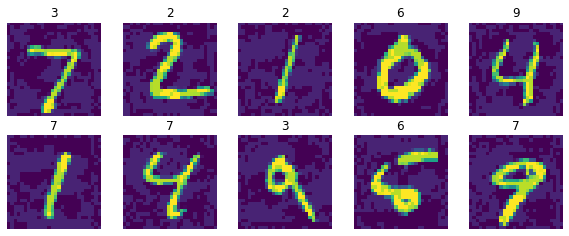

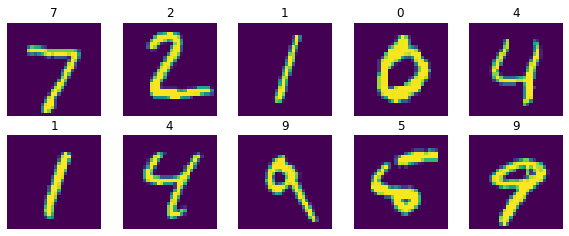

In [13]:
show_batch(x_fgm, adv_preds)
show_batch(clean_inputs,clean_preds)